In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.util import pairplot
import time
from epi.STG_Circuit import NetworkFreq, Simulate_all, NetworkFreq_all
import tensorflow as tf
import os
DTYPE = tf.float32
print('tf version', tf.__version__)
figdir = "../../written/eLifeRevision/figures/fig1/"
talkdir = "/Users/sbittner/Documents/git_repos/dsn_talk/epi_figs/"

tf version 2.4.0


In [2]:
g_el = Parameter("g_el", 1, lb=4., ub=8.)
g_synA = Parameter("g_synA", 1, lb=0.01, ub=4.)

# Define model
sigma_I = 1e-12
#name = "STG"
name = "STG_sigmaI=%.2E" % sigma_I
parameters = [g_el, g_synA]
model = Model(name, parameters)

In [3]:
# Emergent property values.
mu_std = 0.025
mu = np.array([0.55, mu_std**2])
dt = 0.025
T = 300
network_freq = NetworkFreq(dt, T, sigma_I, mu)
model.set_eps(network_freq)

In [4]:
epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['mu'] = [ep['mu'] for ep in epi_df['EP']]
epi_df['elemwise_fn'] = ['spline' if 'spline' in path else 'affine' for path in epi_df['path']]
#epi_df['elemwise_fn'] = [arch['elemwise_fn'] for arch in epi_df['arch']]
epi_df['batch_norm'] = [arch['batch_norm'] for arch in epi_df['arch']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['num_layers'] = [arch['num_layers'] for arch in epi_df['arch']]
epi_df['num_units'] = [arch['num_units'] for arch in epi_df['arch']]
epi_df['random_seed'] = [arch['random_seed'] for arch in epi_df['arch']]

# select by c0
epi_df = epi_df[epi_df['c0']==1e5]
epi_df = epi_df[epi_df['elemwise_fn']=='affine']
epi_df = epi_df[~epi_df['batch_norm']]
epi_df = epi_df[epi_df['num_layers']==2]
epi_df = epi_df[epi_df['num_units']==25]
epi_df = epi_df[epi_df['beta']==2.]
epi_df = epi_df[epi_df['random_seed']==2]

epi_df = epi_df[[np.isclose(_mu, mu).all() for _mu in epi_df['mu']]]

paths = sorted(epi_df['path'].unique())
for i, path in enumerate(paths):
    print(i, path)


0 data/epi/STG_sigmaI=1.00E-12/84b429dd14483c8a8093fc871a7e82a9/D2_C3_affine_L2_U25_PA_rs2/94952fa48a0262eceeabdeeddecb6803/N400_lr1.00E-03_c0=1.00E+05_gamma2.50E-01_beta2.00E+00


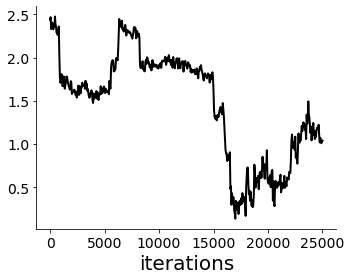

0 -
1 --


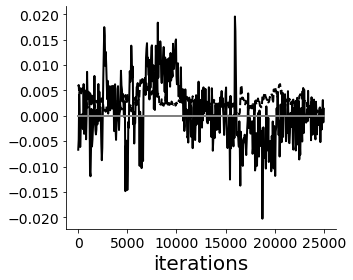

In [5]:
from epi.util import plot_opt

#opt_figdir = "../../written/eLifeRevision/figures/figS4/"
opt_figdir = "./"
for path in paths:
    _epi_df = epi_df[epi_df['path'] == path]
    plot_opt(_epi_df, max_k=5, fontsize=20, figdir=opt_figdir, save=True)


In [6]:
best_Hs = []
convergeds = []
best_ks = []
for path in paths:
    epi_df2 = epi_df[epi_df['path'] == path]
    df_row = epi_df2.iloc[0]
    init = df_row['init']
    init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
    nf = model._df_row_to_nf(df_row)
    aug_lag_hps = model._df_row_to_al_hps(df_row)
    best_k, converged, best_H = model.get_convergence_epoch(init_params, nf, mu, aug_lag_hps, 
                                    alpha=0.05, nu=0.25)
    print(best_k, best_H)
    best_Hs.append(best_H)
    convergeds.append(converged)
    best_ks.append(best_k)
    
bestHs = np.array(best_Hs)
best_ks = np.array(best_ks)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


5: 0.75_0.74
5 1.0333223


In [7]:
best_Hs = np.array([x if x is not None else np.nan for x in best_Hs])
ind = np.nanargmax(best_Hs)

path = paths[ind]
print(path)
best_k = int(best_ks[ind])
best_H = best_Hs[ind]
dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

data/epi/STG_sigmaI=1.00E-12/84b429dd14483c8a8093fc871a7e82a9/D2_C3_affine_L2_U25_PA_rs2/94952fa48a0262eceeabdeeddecb6803/N400_lr1.00E-03_c0=1.00E+05_gamma2.50E-01_beta2.00E+00


In [8]:
remove_outliers = False
M = 500
s = 50

z, log_q_z = dist.nf(M)
z = z.numpy()
log_q_z = log_q_z.numpy()

T_x = model.eps(z)

z_mode = z[np.argmax(log_q_z),:][None,:]
print(z_mode)

[[6.1071167 1.3093035]]


calculating T_x_grid
[[0.00649005 0.00814061 0.00856051 ... 0.00089544 0.0017971  0.00136896]
 [0.00658374 0.0082926  0.00669565 ... 0.00065241 0.00099375 0.001051  ]
 [0.00858704 0.00857063 0.00663659 ... 0.00089326 0.00170908 0.00176364]
 ...
 [0.00098328 0.0012142  0.00164785 ... 0.00077759 0.00062261 0.00072815]
 [0.00070386 0.00135516 0.00167175 ... 0.00068264 0.00063718 0.00054276]
 [0.00088671 0.00087877 0.00137947 ... 0.00047351 0.00062837 0.00080319]]


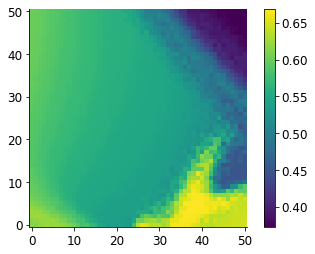

In [36]:
_g_el = Parameter("g_el", 1, lb=4., ub=8.)
_g_synA = Parameter("g_synA", 1, lb=0.01, ub=4.)

# Define model
_parameters = [g_el, g_synA]
_model = Model(name, _parameters)
_dt = 0.025
_T = 300
_sigma_I = 0.
_network_freq = NetworkFreq(_dt, _T, sigma_I, mu)
_model.set_eps(_network_freq)

xlim = [np.min(z[:,1]), np.max(z[:,1])]
ylim = [np.min(z[:,0]), np.max(z[:,0])]
limbuf = 0.

K = 51
x = np.linspace(xlim[0]+limbuf, xlim[1]-limbuf, K)
y = np.linspace(ylim[0]+limbuf, ylim[1]-limbuf, K)
m = K**2

Z_mesh = np.meshgrid(x, y, indexing='ij')
_Z_grid = np.zeros((m,2))
_Z_grid[:,0] = np.reshape(Z_mesh[1], (m,))
_Z_grid[:,1] = np.reshape(Z_mesh[0], (m,))

print("calculating T_x_grid")
T_x_grids = []
N_T_x = 25
for i in range(N_T_x):
    print('%2d/%2d\r' % (i+1, N_T_x), end="")
    T_x_grids.append(np.reshape(_model.eps(_Z_grid)[:,0], (K, K)))
T_x_grids = np.array(T_x_grids)
T_x_grid = np.mean(T_x_grids, axis=0)
T_x_grid_std = np.std(T_x_grids, axis=0)
print(T_x_grid_std)

#num_levels = 7
#levels = np.linspace(0.525, 0.575, num_levels)
plt.imshow(T_x_grid.T, origin='lower')
plt.colorbar()

In [54]:
_T_x_grid = T_x_grid.copy()
#T_x_grid = _T_x_grid.copy()

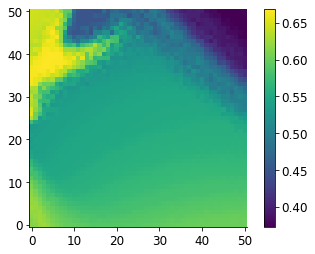

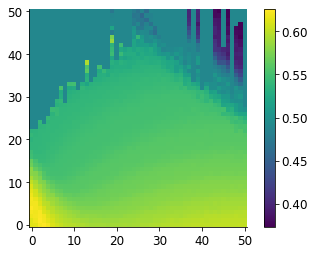

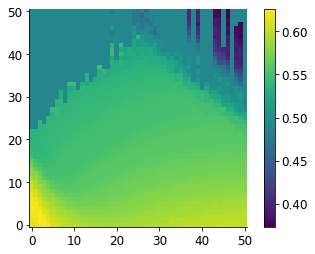

In [55]:
#plt.imshow(T_x_grid, origin='lower')
#plt.colorbar()
#plt.show()

for k in range(K):
    for j in range(20,K):
        if ((T_x_grid[j,k] > T_x_grid[j-1,k]) and
            (T_x_grid[j-1,k] > T_x_grid[j-2,k])):
            T_x_grid[(j-2):,k] = .49
            break
#plt.imshow(T_x_grid, origin='lower')
#plt.colorbar()
#plt.show()

temp = T_x_grid[30:]
temp[temp > .55] = .49
T_x_grid[30:] = temp
            
#plt.imshow(T_x_grid, origin='lower')
#plt.colorbar()
#plt.show()


In [41]:
print('calculate hessian')
start_time = time.time()
hess = dist.hessian(z_mode)
total_time = time.time() - start_time
print('took', total_time, 'seconds')


calculate hessian
took 11.67099380493164 seconds


In [42]:
d, V = np.linalg.eig(hess[0])
d_order = np.argsort(d)
d = np.array([d[i] for i in d_order])
V = np.array([V[:,i] for i in d_order])

if (V[0,0] > 0):
    V[:,0] = -V[:,0]
if (V[0,1] < 0):
    V[:,1] = -V[:,1]
print(d)
print(V)

[-20.149242  -1.461597]
[[-0.35643974  0.9343183 ]
 [ 0.9343183   0.35643974]]


In [43]:
H_tf = np.array([[0.00199881, 0.00420201], [0.00419833, -0.06453793]])
print(H_tf)
d_tf, V_tf = np.linalg.eig(H_tf)
print(d_tf)
print(V_tf)

[[ 0.00199881  0.00420201]
 [ 0.00419833 -0.06453793]]
[ 0.0022629  -0.06480202]
[[ 0.99803087 -0.06277948]
 [ 0.06272471  0.99802742]]


(502,)


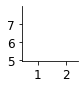

In [44]:
V_proj = 1.2
z1 = z_mode + V_proj*V[:,0][None,:]
z2 = z_mode + V_proj*V[:,1][None,:]
z_stars = np.concatenate((z_mode, z1,z2), axis=0)

log_q_z_stars = dist.log_prob(z_stars)
plt.figure(figsize=(1,1))
sc = plt.scatter(z[:,1], z[:,0], log_q_z)

log_q_zs_c = np.concatenate((log_q_z, log_q_z_stars[[0, 2]]), axis=0)
print(log_q_zs_c.shape)
cs = sc.to_rgba(log_q_zs_c)
c_star = np.array([cs[-2], cs[np.argmin(log_q_zs_c)], cs[-1]])

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


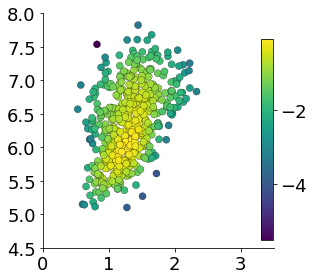

In [45]:
labels = ["", ""]
fig, axs = pairplot(z, range(2), labels, figsize=(4,4), s=s,
                     fontsize=22, lb=np.array([4.5, 0.]), ub=np.array([8, 3.5]),
                     c=log_q_z, c_label='')
plt.tight_layout()
#plt.savefig(os.path.join(talkdir, "EPI_STG_basic.png"))

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


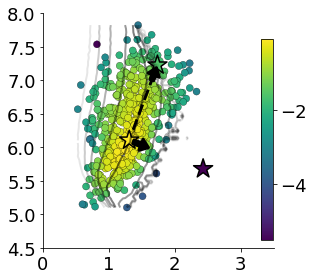

In [58]:
alpha_c_star = 0.8
#c_star = [np.concatenate((.0*np.ones(3,), np.array([alpha_c_star]))),
#             np.concatenate((.7*np.ones((3,)), np.array([alpha_c_star])))]
#c_star = ['k', 'b', 'r']

num_levels = 11
levels = np.linspace(0.5, 0.6, num_levels)

fig, axs = plt.subplots(1,1,figsize=(4,4))
colors = np.zeros((num_levels, 4))
mid_level_ind = (num_levels-1)//2
colors[:,3] = 0.5*(1. - np.abs((np.arange(num_levels) - mid_level_ind) /mid_level_ind))
axs.contour(Z_mesh[0], Z_mesh[1], T_x_grid, levels, colors=colors)

v_scale_start1 = .3
v_scale_start2 = .2
v_scale_end = 1.4
v1_start = (z_mode[0,0] + (v_scale_start1 / np.sqrt(np.abs(d[0]))*V[0,0]), 
            z_mode[0,1] + (v_scale_start1 / np.sqrt(np.abs(d[0]))*V[1,0]))
v2_start = (z_mode[0,0] + (v_scale_start2 / np.sqrt(np.abs(d[1]))*V[0,1]), 
            z_mode[0,1] + (v_scale_start2 / np.sqrt(np.abs(d[1]))*V[1,1]))
v1_end = (z_mode[0,0] + (v_scale_end / np.sqrt(np.abs(d[0]))*V[0,0]), 
          z_mode[0,1] + (v_scale_end / np.sqrt(np.abs(d[0]))*V[1,0]))
v2_end = (z_mode[0,0] + (v_scale_end / np.sqrt(np.abs(d[1]))*V[0,1]), 
          z_mode[0,1] + (v_scale_end / np.sqrt(np.abs(d[1]))*V[1,1]))

ratio = 0.8
v2_mid = ((1-ratio)*v2_start[0]+ratio*v2_end[0], (1-ratio)*v2_start[1]+ratio*v2_end[1])
axs.plot([v2_start[1], v2_mid[1]], [v2_start[0], v2_mid[0]], 'k--', lw=3)
axs.annotate("", xy=[v1_end[1], v1_end[0]], xytext=[v1_start[1], v1_start[0]], 
             arrowprops=dict(headwidth=12, headlength=8, lw=3, color='k'))
axs.annotate("", xy=[v2_end[1], v2_end[0]], xytext=[v2_mid[1], v2_mid[0]], 
             arrowprops=dict(headwidth=12, headlength=8, lw=3, color='k'))

#labels = [r"$g_{el}$", r"$g_{synA}$"]
fig, axs = pairplot(z, range(2), labels, s=s, subplots=(fig,axs),
                     fontsize=22, lb=np.array([4.5, 0.]), ub=np.array([8, 3.5]),
                     c=log_q_z, c_label='', starred=z_stars, c_starred=c_star)

plt.tight_layout()
plt.savefig(figdir + 'EPI_z.png', dpi=300)

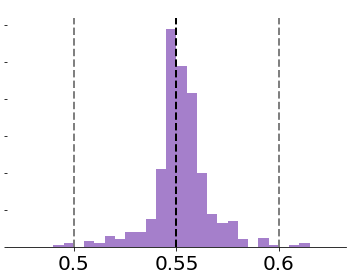

In [16]:
from epi.util import plot_T_x

T_x = T_x.numpy()
#xlabels = [r"$\omega_{hub}(x; z)$"]
xlabels = [""]
ax = plot_T_x(None, T_x[:,0], xmin=0.475, xmax=0.625, 
         x_mean = mu[0], x_std = np.sqrt(mu[1]),
         xlabel=xlabels[0], figsize=(5,4), #figsize=(5,2.25), 
         fontsize=24)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.spines['left'].set_visible(False)

plt.tight_layout()
#plt.savefig(os.path.join(talkdir, 'STG_Tx.png'), transparent=True)
#plt.savefig(os.path.join(figdir, 'Tx.png'), transparent=True)

In [23]:
print(z_stars)
dt = 0.025
T = 2000
simulate_all = Simulate_all(dt, T, sigma_I)
x_ts = [simulate_all(np.array([[z_stars[i,0]]]), np.array([[z_stars[i,1]]])) for i in range(3)]

[[6.1071167 1.3093035]
 [5.679389  2.4304855]
 [7.2282987 1.7370312]]


In [24]:
network_freq_all = NetworkFreq_all(dt, 2000, sigma_I, mu)
omegas = [network_freq_all(np.array([[z_stars[i,0]]]), np.array([[z_stars[i,1]]])) for i in range(3)]

tf.Tensor([0.55 0.55 0.55 0.55 0.55], shape=(5,), dtype=float32)


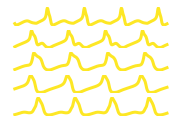

tf.Tensor([0.66999996 0.66999996 0.45       0.45       0.45      ], shape=(5,), dtype=float32)


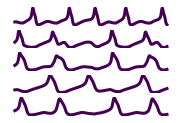

tf.Tensor([0.53999996 0.53999996 0.53999996 0.53999996 0.53999996], shape=(5,), dtype=float32)


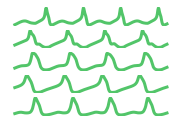

In [53]:
T_plot = 301
t = dt*np.arange(T_plot)
num_neurons = 5
figsize = (3,num_neurons*0.4)
for i in range(3):
    fig, axs = plt.subplots(num_neurons, 1, figsize=figsize)
    print(omegas[i][:5,0])
    for k in range(num_neurons):
        axs[k].plot(t, x_ts[i][-T_plot:,k], color=c_star[i], lw=3)
        axs[k].spines['bottom'].set_visible(False)
        axs[k].spines['left'].set_visible(False)
        axs[k].set_xticks([])
        axs[k].set_yticks([])
    #plt.savefig(os.path.join(figdir, 'x_%d.png' % (i+1)), transparent=True)
    plt.savefig(os.path.join(talkdir, 'x_%d.png' % (i+1)), transparent=True)
    plt.show()
    

In [70]:
print(z_stars)
dt = 0.025
T = 2000
sigma_I = 5e-13
simulate_all = Simulate_all(dt, T, sigma_I)
x_t = simulate_all(np.array([[4.5]]), np.array([[3.]]))
omega = network_freq_all(np.array([[4.5]]), np.array([[3.]]))

[[6.1071167 1.3093035]
 [5.679389  2.4304855]
 [7.2282987 1.7370312]]


tf.Tensor(
[[0.6811134  0.01719073]
 [0.6822561  0.01749167]
 [0.34871814 0.04051439]
 [0.33297828 0.04709843]
 [0.34709665 0.04116977]
 [0.68       0.0169    ]
 [0.68       0.0169    ]
 [0.34       0.04410001]
 [0.32999998 0.04840001]
 [0.34       0.04410001]
 [0.66020095 0.01214425]
 [0.6710097  0.01464335]
 [0.3299998  0.04840009]
 [0.3491916  0.04032402]
 [0.33011407 0.04834983]], shape=(15, 2), dtype=float32)


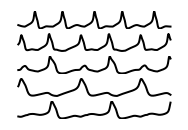

In [71]:
fig, axs = plt.subplots(num_neurons, 1, figsize=figsize)
print(omega)
for k in range(num_neurons):
    axs[k].plot(t, x_t[-T_plot:,k], color='k', lw=2)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
    axs[k].set_xticks([])
    axs[k].set_yticks([])
plt.savefig(os.path.join(figdir, 'x_eg.png'), transparent=True)
plt.show()

In [48]:
from epi.STG_Circuit import Simulate
T = 350
simulate = Simulate(dt, T, sigma_I)
x_t = simulate(z[:,0][:,None], z[:,1][:,None]).numpy()


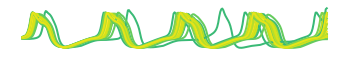

In [51]:
figsize = (6,0.8)
n_plot = 25
to_plot = -2. < log_q_z 
#to_plot = np.logical_and(-2. < log_q_z, log_q_z  < 0.) 
x_t_plot = x_t[:, to_plot]
cs_plot = cs[:-2][to_plot]
fig, axs = plt.subplots(1, 1, figsize=figsize)
for i in range(n_plot):
    axs.plot(t, x_t_plot[-T_plot:,i], color=cs_plot[i], lw=2)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_xticks([])
axs.set_yticks([])
#plt.savefig(os.path.join(talkdir, 'EP_STG.png'), transparent=True)
#plt.savefig(os.path.join(figdir, 'x_EP.jpg'), transparent=True)
plt.show()